In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Ensemble methods

There is a class of Machine Learning algorithms, the so-called **ensemble methods** that aim to **combine the predictions of several simpler estimators** to generate a **more robust final prediction**.

The ensemble methods are usually divided into two classes:

- **Average methods**: have as a general procedure to build several independent estimators, and take the average of their predictions as the final prediction. The main objective of the method is to reduce **variance**, so that the final model is better than all individual models (**random forest**)

- **Boosting methods**: have as a general procedure the construction of estimators sequentially, so that later estimators try to reduce the **bias** of the joint estimator, which takes into account previous estimators (**adaboost**)

There is also a third class of ensemble method, the so-called [stacking ensemble](https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/), which consists of "stacking" models in order to produce the mixture.

The random forest classes are:

- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

- [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)

Both methods have hyperparameters similar to the conventional trees, applied to each of the independent trees. Besides these, there are two very important hyperparameters, referring to the ensemble method itself:

- `n_estimators` : controls how many independent trees will be built. In general, the more trees the better (but the longer it will take). In addition, after a certain number of trees, the results will stop improving, as there is a limit to the bootstrap: after a certain number, the trees are no longer so independent.

- `max_features`: the number of features in the random subset of candidates to be used in each split. The smaller the value, the more we can reduce overfitting, but underfitting is favored. A good heuristic is `max_features=None` for regression and `max_features="sqrt"` for classification, although different strategies can (and should) be tested with CV.


## Random Forest & Bagging

The random forest method creates several different and independent trees, through a random process, and the final prediction is taken through the average of the individual predictions.

<img src="https://i.ytimg.com/vi/goPiwckWE9M/maxresdefault.jpg" width=700>

The Random Forest uses the concepts of **bootstrapping** and **aggregation** (or the composite procedure **bagging**) to create a composite model that is better than a single tree.

<img src="https://c.mql5.com/2/33/image1__1.png" width=600>

### Bootstrapping

The bootstrapping procedure is used in the context of the random forest to generate the so-called **bootstrapped datasets**. For the creation of each bootstrapped dataset:

> select **randomly with replacement** some rows from the original base. This generates the **bootstrapped dataset**, a new (resampled) dataset in which the number of rows is controllable. Then, a decision tree is **trained on this resampled dataset**.

> use only a **random subset of the features** in each split evaluation (`splitter="random"`).

With this, many trees are generated, each following the bootstrap procedure. The bootstrapping procedure introduces **two sources of randomness**, whose objective is to **reduce variance** (tendency to overfitting) of the model. In fact, individual trees are easily overfitted, considering the great flexibility of the hypothesis in finding conditions favorable to learning the noises.

Given the randomization introduced by bootstrapping, the goal is that the trees built are **independent**, so that **the errors committed by each one are independent**.This way, if we consider the isolated predictions and somehow **aggregate** the predictions, the expectation is that the final model is **less prone to overfitting**.

### Aggregation

Once bootstrapping is done, we have several trees, each with its own predictions. Each new observation is passed **for each of the trees** and each tree produces **its target**.

The **aggregation** is used to make the final decision:

> in the case of classification, the final class is assigned as **the majority class**, that is, **the class that was the output $\hat{y}$ most often among all trees**

> in the case of regression, the final value is assigned as **the average of the predicted values $\hat{y}$ by each tree**

In both cases, the aggregation procedure can be seen as an **average**, and sklearn makes this explicit: "*In contrast to the original publication, the scikit-learn implementation combines classifiers by averaging their probabilistic prediction, instead of letting each classifier vote for a single class.*"

Taking the average as an aggregation procedure, the expectation is that **some errors are canceled out**, ensuring a final prediction **more stable and more generalizable**, since the noises are eliminated.

### Bagging

Schematically:

<img src=https://media.geeksforgeeks.org/wp-content/uploads/20210707140912/Bagging.png width=500>

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = pd.read_csv("../data/german-credit-data.csv", index_col=0)

X = df.drop(columns="Risk")
y = df["Risk"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ==========================================================

pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy="mean")),
                              ("std", StandardScaler())])
features_num = X_train.select_dtypes(include=np.number).columns.tolist()

# ==========================================================

pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                              ("onehot", OneHotEncoder())])
features_cat = X_train.select_dtypes(exclude=np.number).columns.tolist()

# ==========================================================

pre_processor = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                     ("transf_cat", pipe_features_cat, features_cat)])

pipe_rf = Pipeline([("pre_processor", pre_processor),
                    ("rf", RandomForestClassifier(random_state=42))])

pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('transf_num',
                                                  Pipeline(steps=[('input_num',
                                                                   SimpleImputer()),
                                                                  ('std',
                                                                   StandardScaler())]),
                                                  ['Age', 'Job',
                                                   'Credit amount',
                                                   'Duration']),
                                                 ('transf_cat',
                                                  Pipeline(steps=[('input_cat',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Sex', 'Housing',
                                                   'Saving accounts',
                                                   'Checking account',
                                                   'Purpose'])])),
                ('rf', RandomForestClassifier(random_state=42))])


Training evaluation metrics:


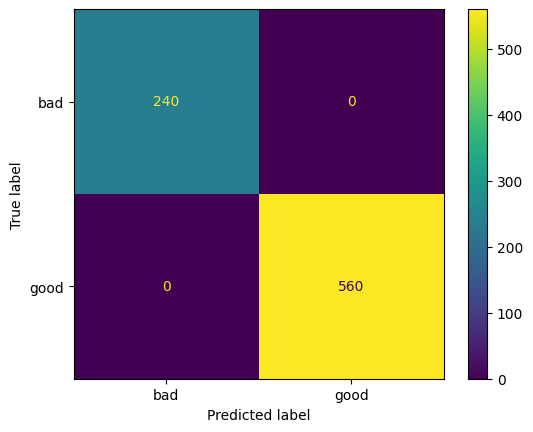

              precision    recall  f1-score   support

         bad       1.00      1.00      1.00       240
        good       1.00      1.00      1.00       560

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800


Test evaluation metrics:


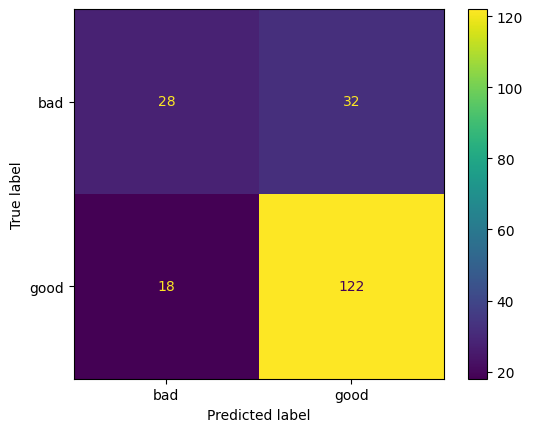

              precision    recall  f1-score   support

         bad       0.61      0.47      0.53        60
        good       0.79      0.87      0.83       140

    accuracy                           0.75       200
   macro avg       0.70      0.67      0.68       200
weighted avg       0.74      0.75      0.74       200



In [4]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# ============================================

print("\nTraining evaluation metrics:")

y_pred_train = pipe_rf.predict(X_train)

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))


# ============================================

print("\nTest evaluation metrics:")

y_pred_test = pipe_rf.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

Despite the good performance on the test, it is evident that the model is overfitted.

This is something very interesting about the random forest: although it is possible to overfit it, **the variance of the generalization error goes to zero, as more trees are added**:

<img src=https://i.stack.imgur.com/8GU8U.png width=500>

That is, a random forest model **tends to be more stable** with respect to generalization. In order to avoid overfitting itself, it can be used the same regularization techniques as individual trees and the number of trees in the forest can be increased.

In [5]:
def pipe_pre_process_german(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy="mean")),
                                  ("std", StandardScaler())])
    features_num = X_train.select_dtypes(include=np.number).columns.tolist()

    pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                                  ("onehot", OneHotEncoder())])
    features_cat = X_train.select_dtypes(exclude=np.number).columns.tolist()

    pre_processor = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                       ("transf_cat", pipe_features_cat, features_cat)])

    return pre_processor


def classification_metrics(estimator):
    print("\nTraining evaluation metrics:")
    y_pred_train = estimator.predict(X_train)
    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
    plt.show()
    print(classification_report(y_train, y_pred_train))

    print("\nTest evaluation metrics:")
    y_pred_test = estimator.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    plt.show()
    print(classification_report(y_test, y_pred_test))
    

In [6]:
df = pd.read_csv("../data/german-credit-data.csv", index_col=0)
X = df.drop(columns="Risk")
y = df["Risk"]

pre_processor = pipe_pre_process_german(X, y)
pipe_rf = Pipeline([("pre_processor", pre_processor),
                     ("rf", RandomForestClassifier(n_estimators=5000,
                                                   max_depth=5,
                                                   random_state=42,
                                                   n_jobs=-1))])

pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('transf_num',
                                                  Pipeline(steps=[('input_num',
                                                                   SimpleImputer()),
                                                                  ('std',
                                                                   StandardScaler())]),
                                                  ['Age', 'Job',
                                                   'Credit amount',
                                                   'Duration']),
                                                 ('transf_cat',
                                                  Pipeline(steps=[('input_cat',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Sex', 'Housing',
                                                   'Saving accounts',
                                                   'Checking account',
                                                   'Purpose'])])),
                ('rf',
                 RandomForestClassifier(max_depth=5, n_estimators=5000,
                                        n_jobs=-1, random_state=42))])


Training evaluation metrics:


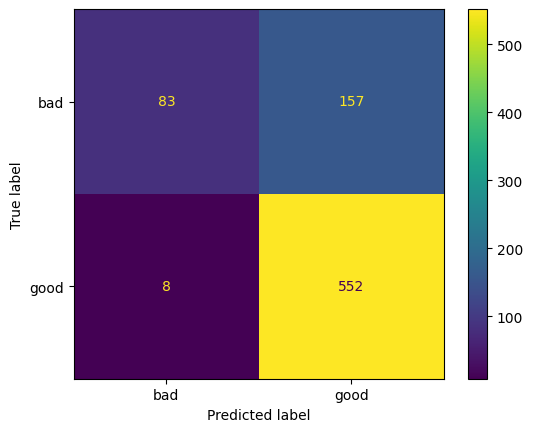

              precision    recall  f1-score   support

         bad       0.91      0.35      0.50       240
        good       0.78      0.99      0.87       560

    accuracy                           0.79       800
   macro avg       0.85      0.67      0.69       800
weighted avg       0.82      0.79      0.76       800


Test evaluation metrics:


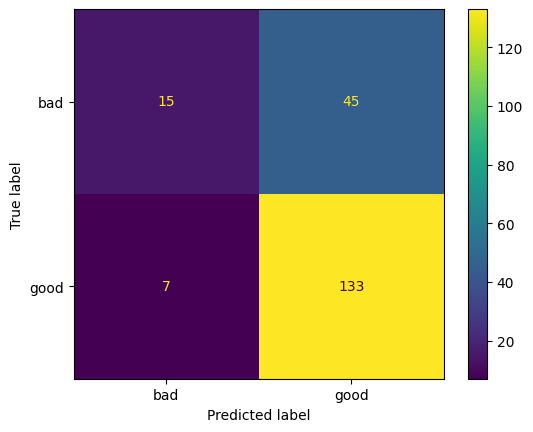

              precision    recall  f1-score   support

         bad       0.68      0.25      0.37        60
        good       0.75      0.95      0.84       140

    accuracy                           0.74       200
   macro avg       0.71      0.60      0.60       200
weighted avg       0.73      0.74      0.70       200



In [7]:
classification_metrics(pipe_rf)

> **TIP**: the random forest is highly parallelizable (after all, the trees are independent). Because of this, it is worth using the `n_jobs` argument to parallelize and speed up calculations.